In [86]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Current date (May 1 for this simulation)
current_date = datetime(2025, 5, 1)

# Asset parameters dictionary
assets = {
    "GOLD": {
        "spot": 9436.00,
        "volatility": 0.18,  # 18% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "OIL": {
        "spot": 5007.38,  #Crude oil
        "volatility": 0.32,  # 32% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "BITCOIN": {
        "spot": 8216447.00,
        "volatility": 0.53,  # 53% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "ICICI_BANK": {
        "spot": 1430.10,  # INR/share
        "volatility": 0.21,  # 21% annualized
        "dividend_yield": 0.007,  # 0.7% dividend yield
    }
}

# Common parameters
risk_free_rate = 0.0635  #annual risk-free rate
time_to_maturity = 1

In [87]:
# Define strikes for each asset
for asset in assets:
    spot = assets[asset]["spot"]

    # ATM strike = spot price
    assets[asset]["strike_ATM"] = spot

    # ITM strike (10% below spot for calls, above for puts)
    assets[asset]["strike_ITM_call"] = spot * 0.9
    assets[asset]["strike_ITM_put"] = spot * 1.1

    # OTM strike (10% above spot for calls, below for puts)
    assets[asset]["strike_OTM_call"] = spot * 1.1
    assets[asset]["strike_OTM_put"] = spot * 0.9

In [88]:
def generate_price_paths(S0, sigma, r, q, T, n_steps, n_simulations):

    np.random.seed(42)
    dt = T / n_steps
    paths = np.zeros((n_simulations, n_steps + 1))
    paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        paths[:, t] = paths[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt
                                            + sigma * np.sqrt(dt) * z)

    return paths

# Simulation parameters
#n_steps = 100  # Number of time steps
#n_simulations = 10000  # Number of simulations

In [89]:
def floating_strike_lookback(paths, option_type, r, T):

    if option_type == 'call':
        # Call payoff: S_T - min(S)
        min_prices = np.min(paths, axis=1)
        payoffs = paths[:, -1] - min_prices
    elif option_type == 'put':
        # Put payoff: max(S) - S_T
        max_prices = np.max(paths, axis=1)
        payoffs = max_prices - paths[:, -1]
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Discounted average payoff
    price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.std(payoffs, ddof=1) / np.sqrt(len(payoffs))

    return price,std_error

In [90]:
def fixed_strike_lookback(paths, option_type, K, r, T):

    if option_type == 'call':
        # Call payoff: max(max(S) - K, 0)
        max_prices = np.max(paths, axis=1)
        payoffs = np.maximum(max_prices - K, 0)
    elif option_type == 'put':
        # Put payoff: max(K - min(S), 0)
        min_prices = np.min(paths, axis=1)
        payoffs = np.maximum(K - min_prices, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Discounted average payoff
    price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.std(payoffs, ddof=1) / np.sqrt(len(payoffs))
    return price,std_error

In [91]:
def calculate_floating_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type):
    """
    Calculate Greeks for floating strike lookback options using pathwise method with antithetic variates.
    """
    # Small perturbations for finite difference calculations
    dS = S0 * 0.01  # 1% of spot for delta/gamma
    dsigma = sigma * 0.01  # 1% of volatility for vega
    dr = r * 0.01  # 1% of risk-free rate for rho
    dT = T * 0.01  # 1% of time for theta

    # Base price calculation
    paths= generate_price_paths(S0, sigma, r, q, T, n_steps, n_simulations)
    base_price, _ = floating_strike_lookback(paths, option_type, r, T)

    # Delta calculation (price sensitivity to spot price)
    paths_up = generate_price_paths(S0 + dS, sigma, r, q, T, n_steps, n_simulations)
    price_up, _ = floating_strike_lookback(paths_up,  option_type, r, T)

    paths_down = generate_price_paths(S0 - dS, sigma, r, q, T, n_steps, n_simulations)
    price_down, _ = floating_strike_lookback(paths_down,  option_type, r, T)

    delta = (price_up - price_down) / (2 * dS)
    gamma = (price_up - 2 * base_price + price_down) / (dS ** 2)

    # Vega calculation (price sensitivity to volatility)
    paths_vega = generate_price_paths(S0, sigma + dsigma, r, q, T, n_steps, n_simulations)
    price_vega, _ = floating_strike_lookback(paths_vega,  option_type, r, T)
    vega = (price_vega - base_price) / dsigma

    # Theta calculation (price sensitivity to time)
    paths_theta = generate_price_paths(S0, sigma, r, q, T - dT, n_steps, n_simulations)
    price_theta, _ = floating_strike_lookback(paths_theta, option_type, r, T - dT)
    theta = (price_theta - base_price) / dT

    # Rho calculation (price sensitivity to interest rate)
    paths_rho = generate_price_paths(S0, sigma, r + dr, q, T, n_steps, n_simulations)
    price_rho, _ = floating_strike_lookback(paths_rho, option_type, r + dr, T)
    rho = (price_rho - base_price) / dr

    return {
        'price': base_price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }

def calculate_fixed_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type, K):
    # Small perturbations for finite difference calculations
    dS = S0 * 0.01  # 1% of spot for delta/gamma
    dsigma = sigma * 0.01  # 1% of volatility for vega
    dr = r * 0.01  # 1% of risk-free rate for rho
    dT = T * 0.01  # 1% of time for theta

    # Base price calculation
    paths = generate_price_paths(S0, sigma, r, q, T, n_steps, n_simulations)
    base_price, _ = fixed_strike_lookback(paths, option_type, K, r, T)

    # Delta calculation (price sensitivity to spot price)
    paths_up = generate_price_paths(S0 + dS, sigma, r, q, T, n_steps, n_simulations)
    price_up, _ = fixed_strike_lookback(paths_up, option_type, K, r, T)

    paths_down = generate_price_paths(S0 - dS, sigma, r, q, T, n_steps, n_simulations)
    price_down, _ = fixed_strike_lookback(paths_down, option_type, K, r, T)

    delta = (price_up - price_down) / (2 * dS)
    gamma = (price_up - 2 * base_price + price_down) / (dS ** 2)

    # Vega calculation (price sensitivity to volatility)
    paths_vega = generate_price_paths(S0, sigma + dsigma, r, q, T, n_steps, n_simulations)
    price_vega, _ = fixed_strike_lookback(paths_vega, option_type, K, r, T)
    vega = (price_vega - base_price) / dsigma

    # Theta calculation (price sensitivity to time)
    paths_theta = generate_price_paths(S0, sigma, r, q, T - dT, n_steps, n_simulations)
    price_theta, _ = fixed_strike_lookback(paths_theta, option_type, K, r, T - dT)
    theta = (price_theta - base_price) / dT

    # Rho calculation (price sensitivity to interest rate)
    paths_rho = generate_price_paths(S0, sigma, r + dr, q, T, n_steps, n_simulations)
    price_rho, _ = fixed_strike_lookback(paths_rho,  option_type, K, r + dr, T)
    rho = (price_rho - base_price) / dr

    return {
        'price': base_price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }

In [92]:
import pandas as pd

# Set simulation parameters
n_steps = 252  # daily steps for 1 year
n_simulations = 1000

# Initialize results storage
floating_results = []
fixed_results = []

# Calculate Greeks for each asset
for asset_name, asset_params in assets.items():
    S0 = asset_params["spot"]
    sigma = asset_params["volatility"]
    q = asset_params["dividend_yield"]

    # Floating strike lookback
    for opt_type in ['call', 'put']:
        floating_greeks = calculate_floating_strike_lookback_greeks(
            S0, sigma, risk_free_rate, q, time_to_maturity,
            n_steps, n_simulations, opt_type
        )
        floating_results.append({
            'Asset': asset_name,
            'Type': f'Floating {opt_type}',
            **floating_greeks
        })

    # Fixed strike lookback (ATM)
    for opt_type in ['call', 'put']:
        K = asset_params[f"strike_ATM"]
        fixed_greeks = calculate_fixed_strike_lookback_greeks(
            S0, sigma, risk_free_rate, q, time_to_maturity,
            n_steps, n_simulations, opt_type, K
        )
        fixed_results.append({
            'Asset': asset_name,
            'Type': f'Fixed ATM {opt_type}',
            **fixed_greeks
        })

    # Fixed strike lookback (ITM/OTM)
    for moneyness in ['ITM', 'OTM']:
        for opt_type in ['call', 'put']:
            strike_key = f"strike_{moneyness}_{opt_type}"
            K = asset_params[strike_key]
            fixed_greeks = calculate_fixed_strike_lookback_greeks(
                S0, sigma, risk_free_rate, q, time_to_maturity,
                n_steps, n_simulations, opt_type, K
            )
            fixed_results.append({
                'Asset': asset_name,
                'Type': f'Fixed {moneyness} {opt_type}',
                **fixed_greeks
            })

# Create DataFrames
floating_df = pd.DataFrame(floating_results)
fixed_df = pd.DataFrame(fixed_results)

# Reorder columns for better readability
column_order = ['Asset', 'Type', 'price', 'delta', 'gamma', 'vega', 'theta', 'rho']
floating_df = floating_df[column_order]
fixed_df = fixed_df[column_order]

# Format the numbers for better display
def format_greeks(df):
    return df.style.format({
        'price': '{:.2f}',
        'delta': '{:.4f}',
        'gamma': '{:.6f}',
        'vega': '{:.4f}',
        'theta': '{:.4f}',
        'rho': '{:.4f}'
    })

# Display results
print("="*80)
print("FLOATING STRIKE LOOKBACK OPTION GREEKS")
print("="*80)
display(format_greeks(floating_df))

print("\n" + "="*80)
print("FIXED STRIKE LOOKBACK OPTION GREEKS")
print("="*80)
display(format_greeks(fixed_df))

FLOATING STRIKE LOOKBACK OPTION GREEKS



FIXED STRIKE LOOKBACK OPTION GREEKS


In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm  # For progress bars

def analyze_spot_price_impact(S0_range, sigma, r, q, T, n_steps, n_simulations, option_type, strike_type='floating', K=None):
    """
    Analyze impact of spot price on option price and delta.

    Args:
        S0_range: Array of spot prices to analyze
        strike_type: 'floating' or 'fixed'
    """
    results = []
    for S in tqdm(S0_range, desc="Analyzing spot price impact"):
        if strike_type == 'floating':
            greeks = calculate_floating_strike_lookback_greeks(S, sigma, r, q, T, n_steps, n_simulations, option_type)
        else:
            greeks = calculate_fixed_strike_lookback_greeks(S, sigma, r, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Spot Price': S,
            'Price': greeks['price'],
            'Delta': greeks['delta'],
            'Gamma': greeks['gamma']
        })

    df = pd.DataFrame(results)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x='Spot Price', y='Price', ax=ax1)
    ax1.set_title(f'Option Price vs Spot Price\n({strike_type} {option_type})')
    ax1.set_ylabel('Option Price')

    sns.lineplot(data=df, x='Spot Price', y='Delta', ax=ax2)
    ax2.set_title(f'Delta vs Spot Price\n({strike_type} {option_type})')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.axhline(1 if option_type == 'call' else -1, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()

    return df

def analyze_strike_price_impact(S0, sigma, r, q, T, n_steps, n_simulations, option_type, moneyness_range=np.linspace(0.7, 1.3, 13)):
    """
    Analyze impact of moneyness (K/S0 ratio) on option price.
    """
    results = []
    for moneyness in tqdm(moneyness_range, desc="Analyzing strike price impact"):
        K = S0 * moneyness
        greeks = calculate_fixed_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Moneyness (K/S0)': moneyness,
            'Strike Price': K,
            'Price': greeks['price'],
            'Delta': greeks['delta'],
            'Gamma': greeks['gamma']
        })

    df = pd.DataFrame(results)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='Moneyness (K/S0)', y='Price')
    plt.title(f'Option Price vs Moneyness\n(Fixed strike {option_type})')
    plt.axvline(1, color='red', linestyle='--', label='ATM')
    plt.legend()
    plt.show()

    return df

def analyze_time_to_maturity_impact(S0, sigma, r, q, T_range, n_steps_per_year, n_simulations, option_type, strike_type='floating', K=None):
    """
    Analyze impact of time to maturity on option price and theta.
    """
    results = []
    for T in tqdm(T_range, desc="Analyzing time impact"):
        n_steps = int(n_steps_per_year * T)
        if strike_type == 'floating':
            greeks = calculate_floating_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type)
        else:
            greeks = calculate_fixed_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Time to Maturity': T,
            'Price': greeks['price'],
            'Theta': greeks['theta']
        })

    df = pd.DataFrame(results)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x='Time to Maturity', y='Price', ax=ax1)
    ax1.set_title(f'Option Price vs Time to Maturity\n({strike_type} {option_type})')
    ax1.set_ylabel('Option Price')

    sns.lineplot(data=df, x='Time to Maturity', y='Theta', ax=ax2)
    ax2.set_title(f'Theta vs Time to Maturity\n({strike_type} {option_type})')
    ax2.set_ylabel('Theta (1 day decay)')

    plt.tight_layout()
    plt.show()

    return df

def analyze_volatility_impact(S0, sigma_range, r, q, T, n_steps, n_simulations, option_type, strike_type='floating', K=None):
    """
    Analyze impact of volatility on option price, vega and gamma.
    """
    results = []
    for vol in tqdm(sigma_range, desc="Analyzing volatility impact"):
        if strike_type == 'floating':
            greeks = calculate_floating_strike_lookback_greeks(S0, vol, r, q, T, n_steps, n_simulations, option_type)
        else:
            greeks = calculate_fixed_strike_lookback_greeks(S0, vol, r, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Volatility': vol,
            'Price': greeks['price'],
            'Vega': greeks['vega'],
            'Gamma': greeks['gamma']
        })

    df = pd.DataFrame(results)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    sns.lineplot(data=df, x='Volatility', y='Price', ax=ax1)
    ax1.set_title(f'Option Price vs Volatility\n({strike_type} {option_type})')

    sns.lineplot(data=df, x='Volatility', y='Vega', ax=ax2)
    ax2.set_title(f'Vega vs Volatility\n({strike_type} {option_type})')

    sns.lineplot(data=df, x='Volatility', y='Gamma', ax=ax3)
    ax3.set_title(f'Gamma vs Volatility\n({strike_type} {option_type})')

    plt.tight_layout()
    plt.show()

    return df

def analyze_interest_rate_impact(S0, sigma, r_range, q, T, n_steps, n_simulations, option_type, strike_type='floating', K=None):
    """
    Analyze impact of interest rates on option price and rho.
    """
    results = []
    for rate in tqdm(r_range, desc="Analyzing rate impact"):
        if strike_type == 'floating':
            greeks = calculate_floating_strike_lookback_greeks(S0, sigma, rate, q, T, n_steps, n_simulations, option_type)
        else:
            greeks = calculate_fixed_strike_lookback_greeks(S0, sigma, rate, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Interest Rate': rate,
            'Price': greeks['price'],
            'Rho': greeks['rho']
        })

    df = pd.DataFrame(results)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x='Interest Rate', y='Price', ax=ax1)
    ax1.set_title(f'Option Price vs Interest Rate\n({strike_type} {option_type})')

    sns.lineplot(data=df, x='Interest Rate', y='Rho', ax=ax2)
    ax2.set_title(f'Rho vs Interest Rate\n({strike_type} {option_type})')

    plt.tight_layout()
    plt.show()

    return df

def analyze_dividend_impact(S0, sigma, r, q_range, T, n_steps, n_simulations, option_type, strike_type='floating', K=None):
    """
    Analyze impact of dividend yield on option price.
    """
    results = []
    for q in tqdm(q_range, desc="Analyzing dividend impact"):
        if strike_type == 'floating':
            greeks = calculate_floating_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type)
        else:
            greeks = calculate_fixed_strike_lookback_greeks(S0, sigma, r, q, T, n_steps, n_simulations, option_type, K)

        results.append({
            'Dividend Yield': q,
            'Price': greeks['price'],
            'Delta': greeks['delta']
        })

    df = pd.DataFrame(results)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x='Dividend Yield', y='Price', ax=ax1)
    ax1.set_title(f'Option Price vs Dividend Yield\n({strike_type} {option_type})')

    sns.lineplot(data=df, x='Dividend Yield', y='Delta', ax=ax2)
    ax2.set_title(f'Delta vs Dividend Yield\n({strike_type} {option_type})')

    plt.tight_layout()
    plt.show()

    return df

def generate_parameter_impact_report(asset_name, asset_params, risk_free_rate, time_to_maturity):
    """
    Generate complete parameter impact report for a given asset.
    """
    print(f"\n{'='*80}")
    print(f"PARAMETER IMPACT ANALYSIS FOR {asset_name.upper()}")
    print(f"{'='*80}")

    S0 = asset_params["spot"]
    sigma = asset_params["volatility"]
    q = asset_params["dividend_yield"]
    K_atm = asset_params["strike_ATM"]

    # Common parameters
    n_steps = 252
    n_simulations = 10000  # Reduced for faster analysis

    # 1. Spot Price Impact

    S0_range = np.linspace(S0*0.7, S0*1.3, 13)
    print("\n1. Spot Price Impact (Floating Strike Call):")
    spot_df = analyze_spot_price_impact(S0_range, sigma, risk_free_rate, q, time_to_maturity,
                                      n_steps, n_simulations, 'call', 'floating')
    S0_range = np.linspace(S0*0.7, S0*1.3, 13)
    print("\n1. Spot Price Impact (Floating Strike put):")
    spot_df = analyze_spot_price_impact(S0_range, sigma, risk_free_rate, q, time_to_maturity,
                                      n_steps, n_simulations, 'put', 'floating')

    # 2. Strike Price Impact
    print("\n2. Strike Price Impact (Fixed Strike Call):")
    strike_df = analyze_strike_price_impact(S0, sigma, risk_free_rate, q, time_to_maturity,
                                          n_steps, n_simulations, 'call')

    # 3. Time to Maturity Impact
    T_range = np.linspace(0.1, 2, 10)
    print("\n3. Time to Maturity Impact (Floating Strike Call):")
    time_df = analyze_time_to_maturity_impact(S0, sigma, risk_free_rate, q, T_range,
                                            n_steps, n_simulations, 'call', 'floating')

    # 4. Volatility Impact
    sigma_range = np.linspace(0.1, 0.7, 13)
    print("\n4. Volatility Impact (Floating Strike Call):")
    vol_df = analyze_volatility_impact(S0, sigma_range, risk_free_rate, q, time_to_maturity,
                                     n_steps, n_simulations, 'call', 'floating')

    # 5. Interest Rate Impact
    r_range = np.linspace(0.01, 0.15, 10)
    print("\n5. Interest Rate Impact (Floating Strike Call):")
    rate_df = analyze_interest_rate_impact(S0, sigma, r_range, q, time_to_maturity,
                                         n_steps, n_simulations, 'call', 'floating')

    # 6. Dividend Impact (if applicable)
    if q > 0:
        q_range = np.linspace(0, q*2, 10)
        print("\n6. Dividend Yield Impact (Floating Strike Call):")
        div_df = analyze_dividend_impact(S0, sigma, risk_free_rate, q_range, time_to_maturity,
                                        n_steps, n_simulations, 'call', 'floating')

    return {
        'spot_impact': spot_df,
        'strike_impact': strike_df,
        'time_impact': time_df,
        'vol_impact': vol_df,
        'rate_impact': rate_df,
        'dividend_impact': div_df if q > 0 else None
    }


PARAMETER IMPACT ANALYSIS FOR BITCOIN

1. Spot Price Impact (Floating Strike Call):


Analyzing spot price impact: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


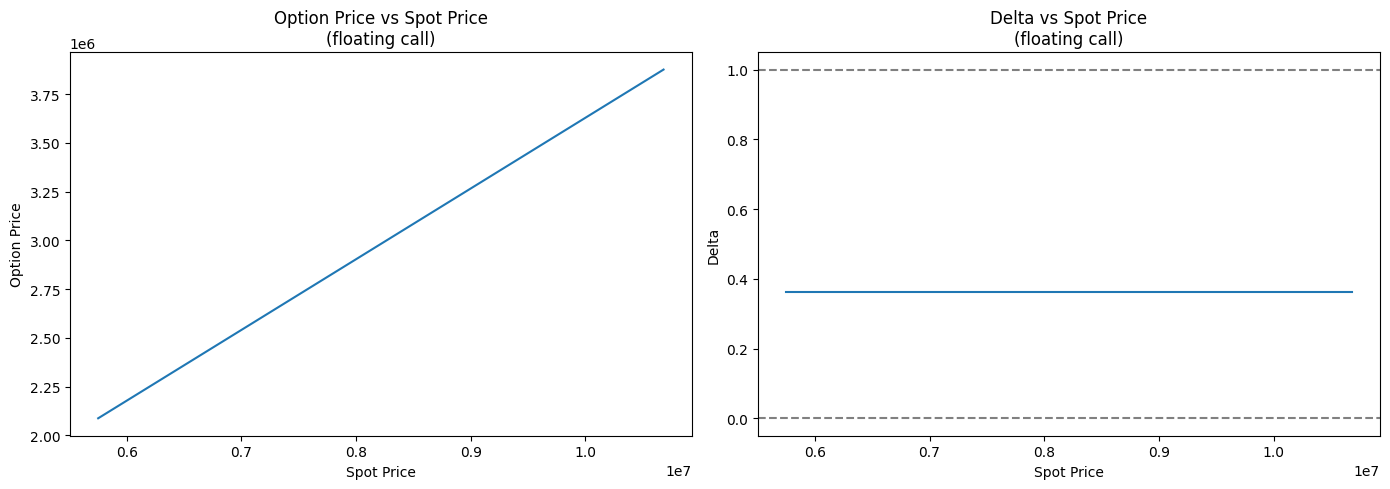


1. Spot Price Impact (Floating Strike put):


Analyzing spot price impact: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


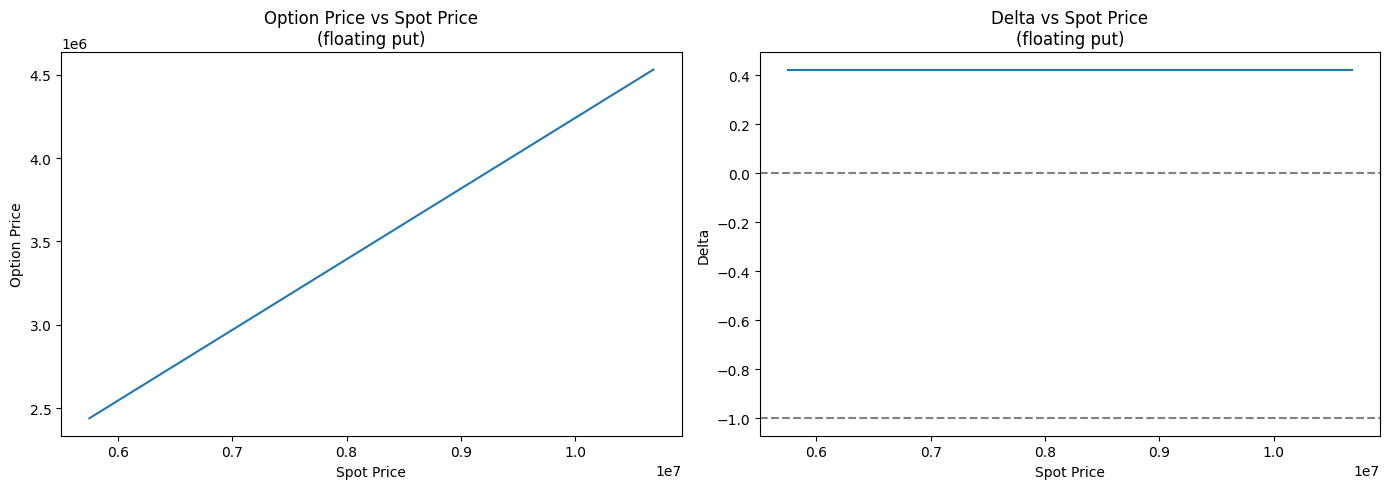


2. Strike Price Impact (Fixed Strike Call):


Analyzing strike price impact: 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


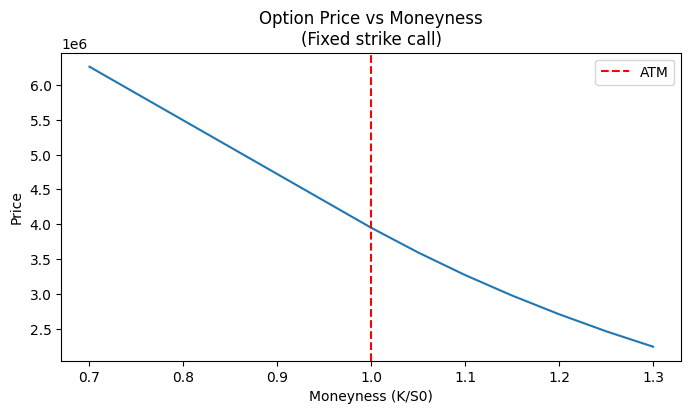


3. Time to Maturity Impact (Floating Strike Call):


Analyzing time impact: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


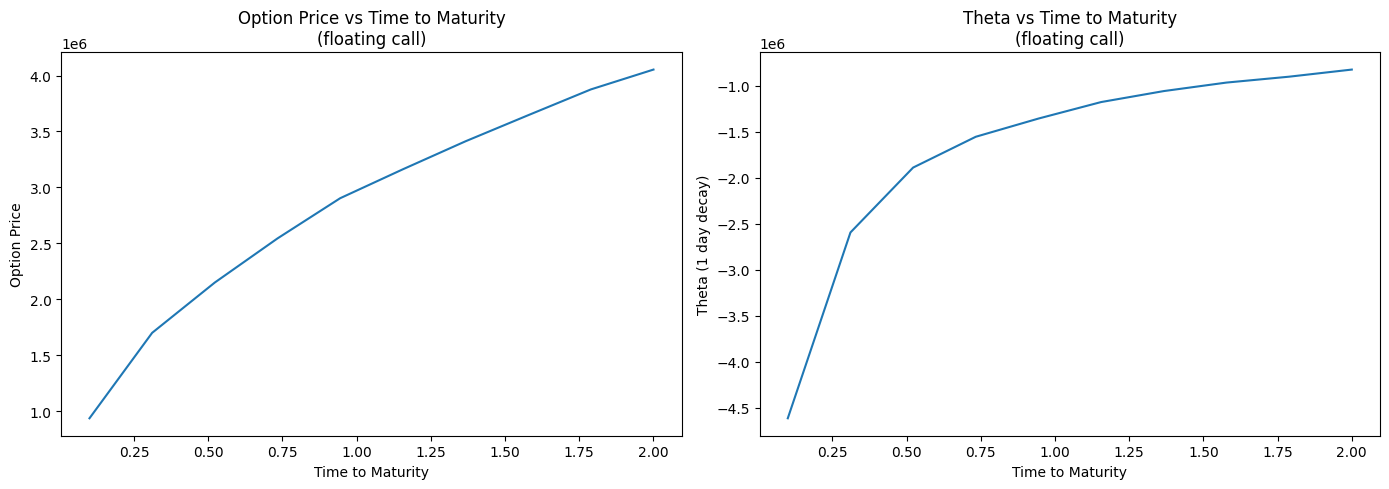


4. Volatility Impact (Floating Strike Call):


Analyzing volatility impact: 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


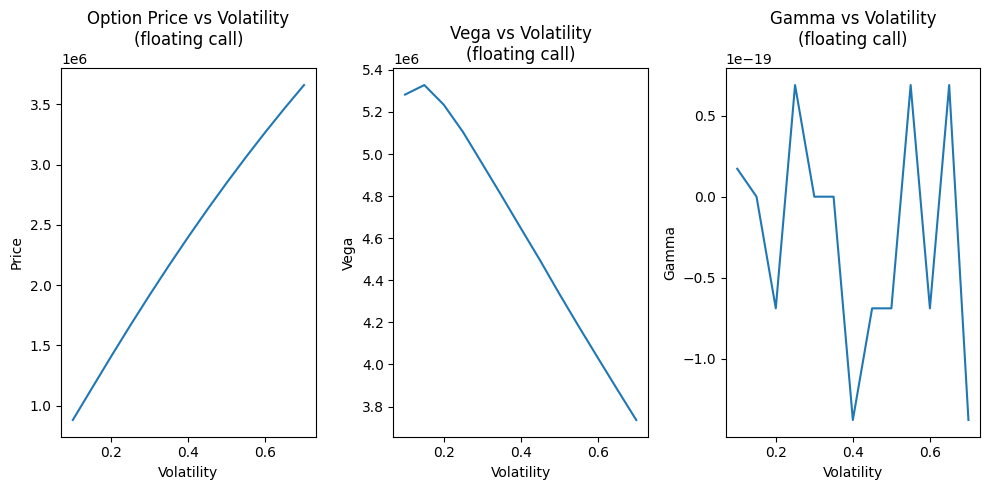


5. Interest Rate Impact (Floating Strike Call):


Analyzing rate impact: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


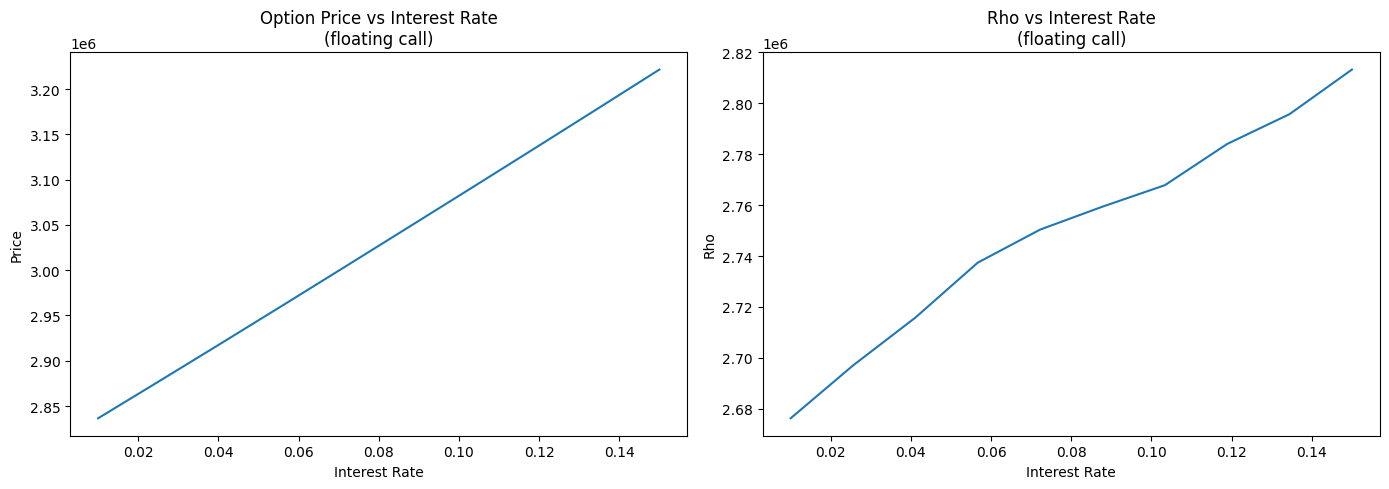

'all_reports = {}\nfor asset_name, asset_params in assets.items():\n    all_reports[asset_name] = generate_parameter_impact_report(\n        asset_name, asset_params, risk_free_rate, time_to_maturity\n    )'

In [115]:
# Generate report for GOLD
bitcoin_report = generate_parameter_impact_report("BITCOIN", assets["BITCOIN"], risk_free_rate, time_to_maturity)


# Generate report for all assets
'''all_reports = {}
for asset_name, asset_params in assets.items():
    all_reports[asset_name] = generate_parameter_impact_report(
        asset_name, asset_params, risk_free_rate, time_to_maturity
    )'''


Analyzing GOLD...


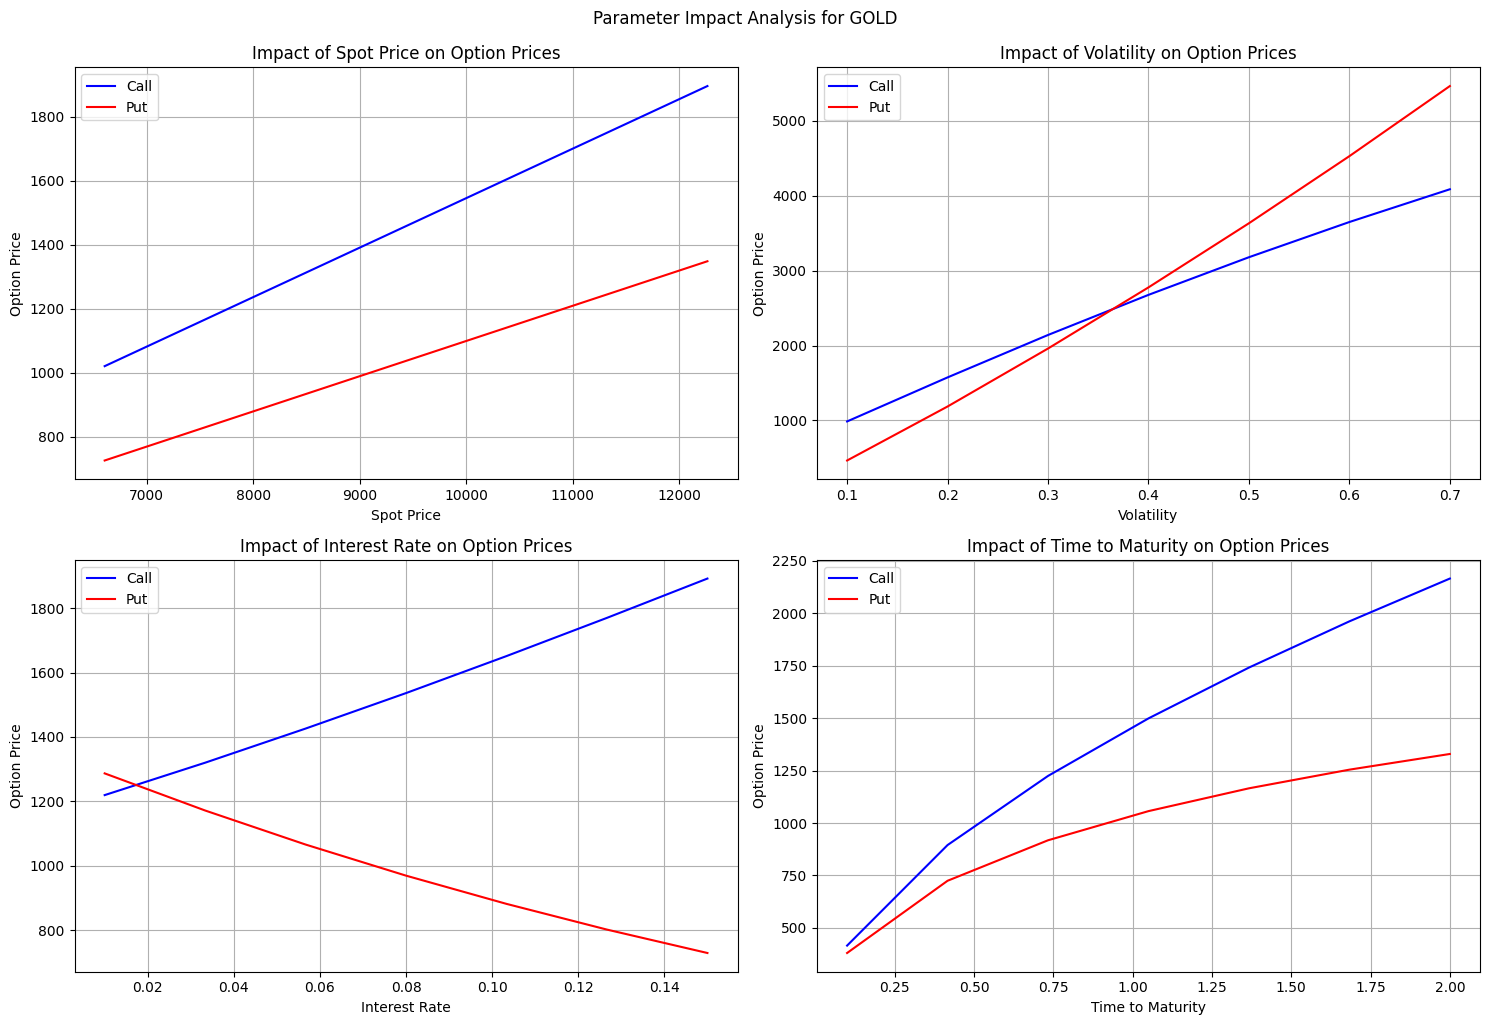


Analyzing OIL...


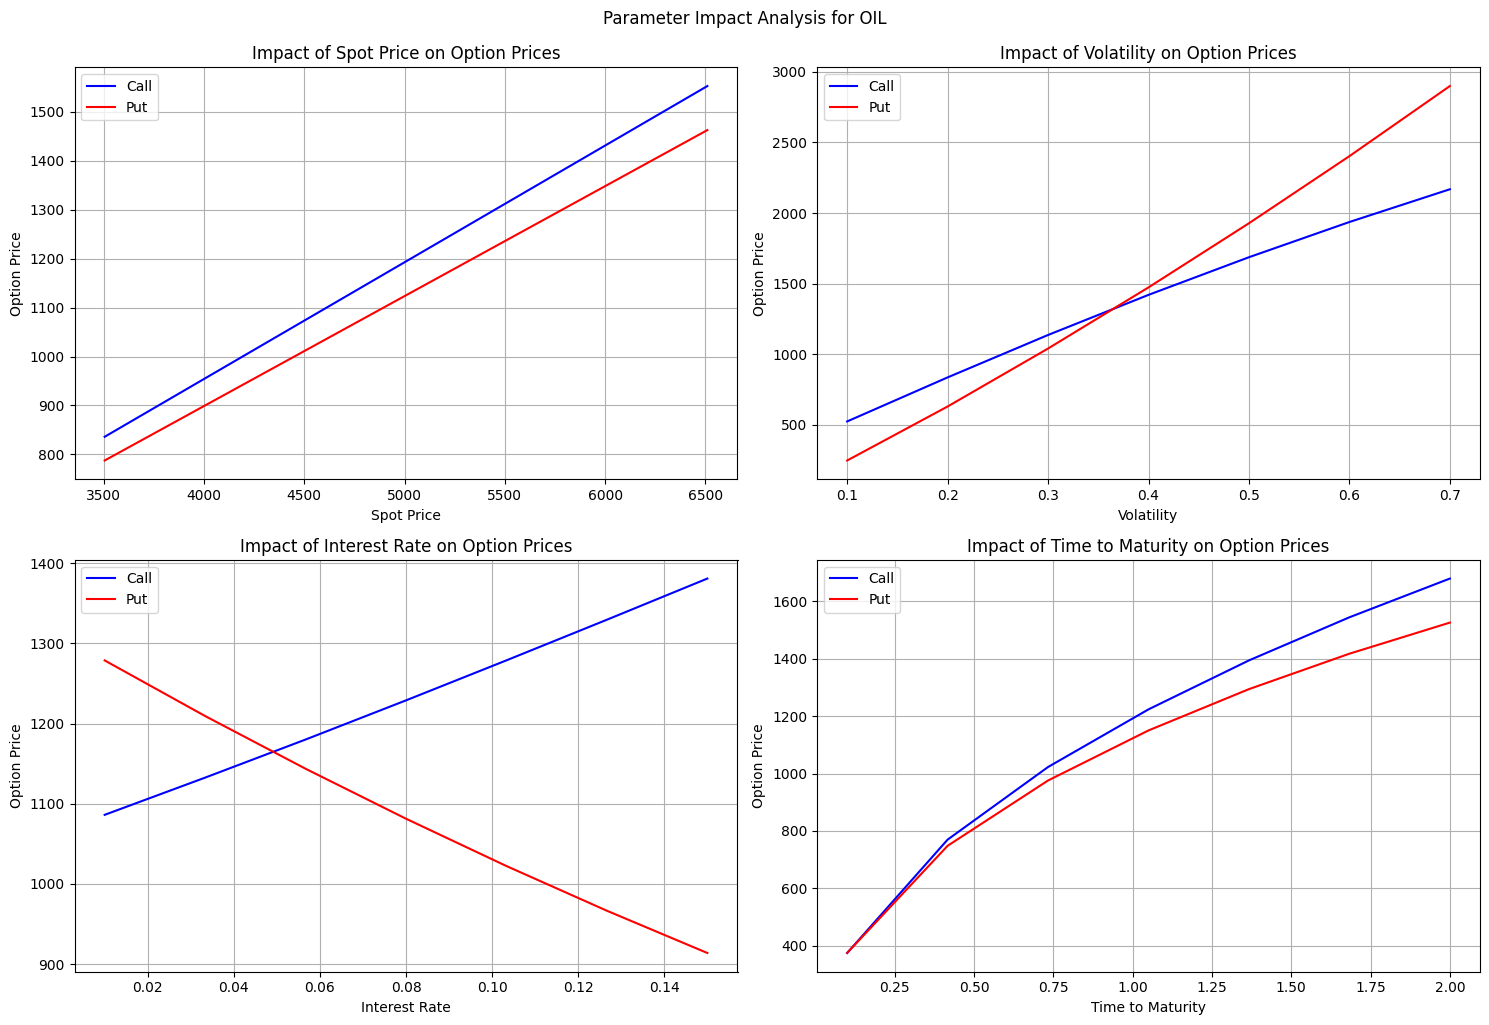


Analyzing BITCOIN...


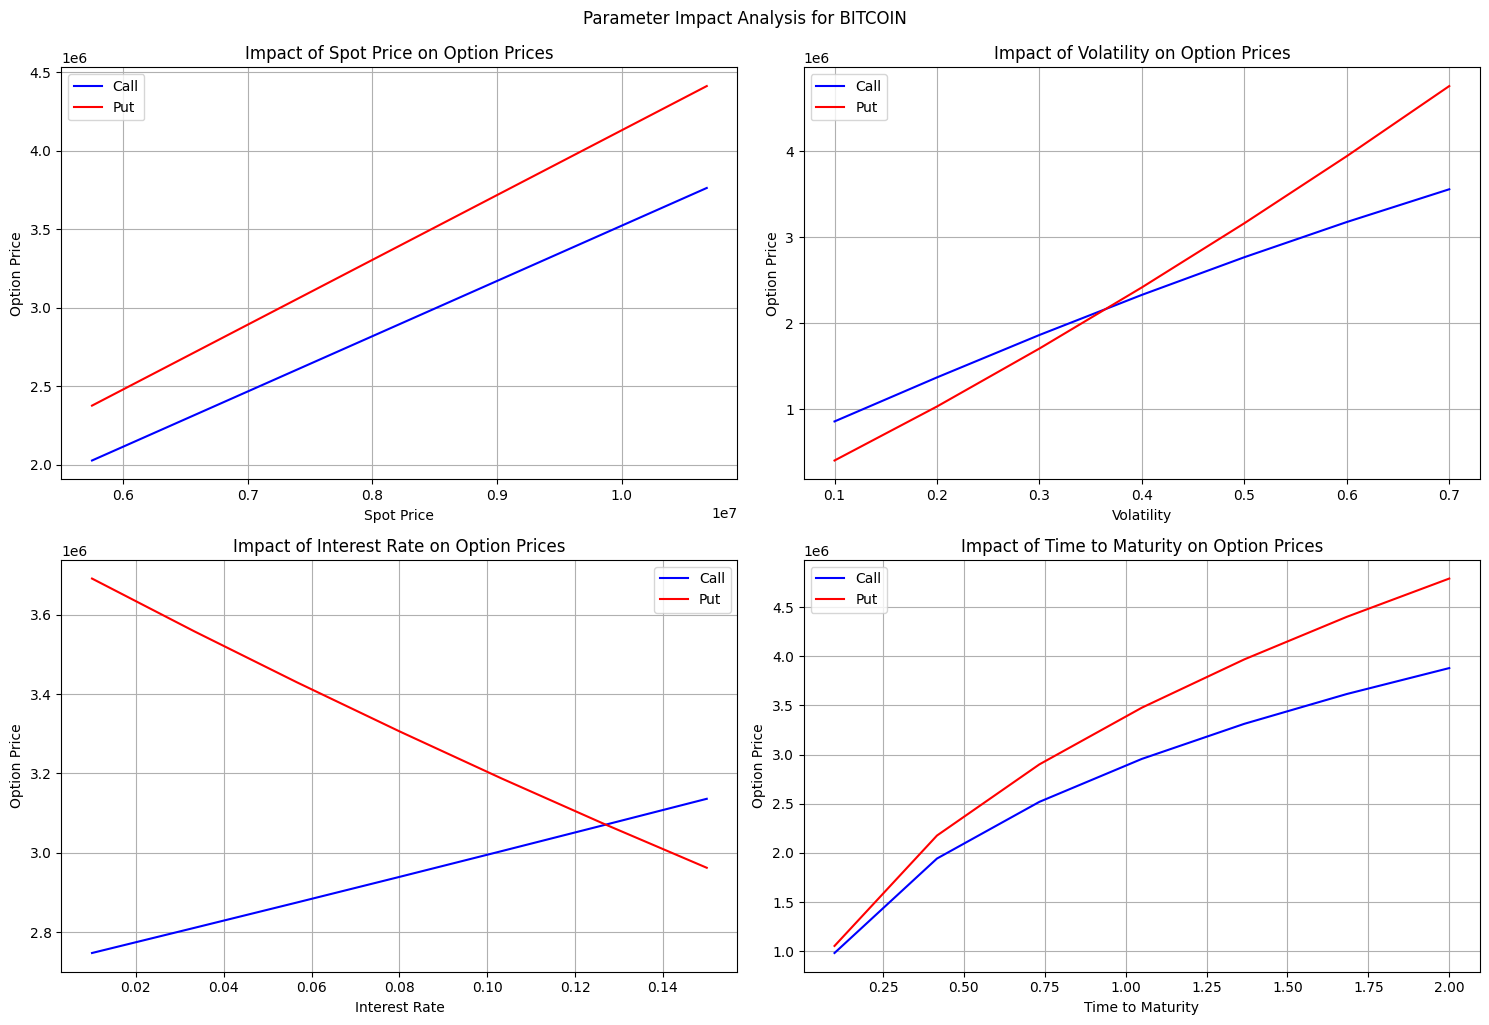


Analyzing ICICI_BANK...


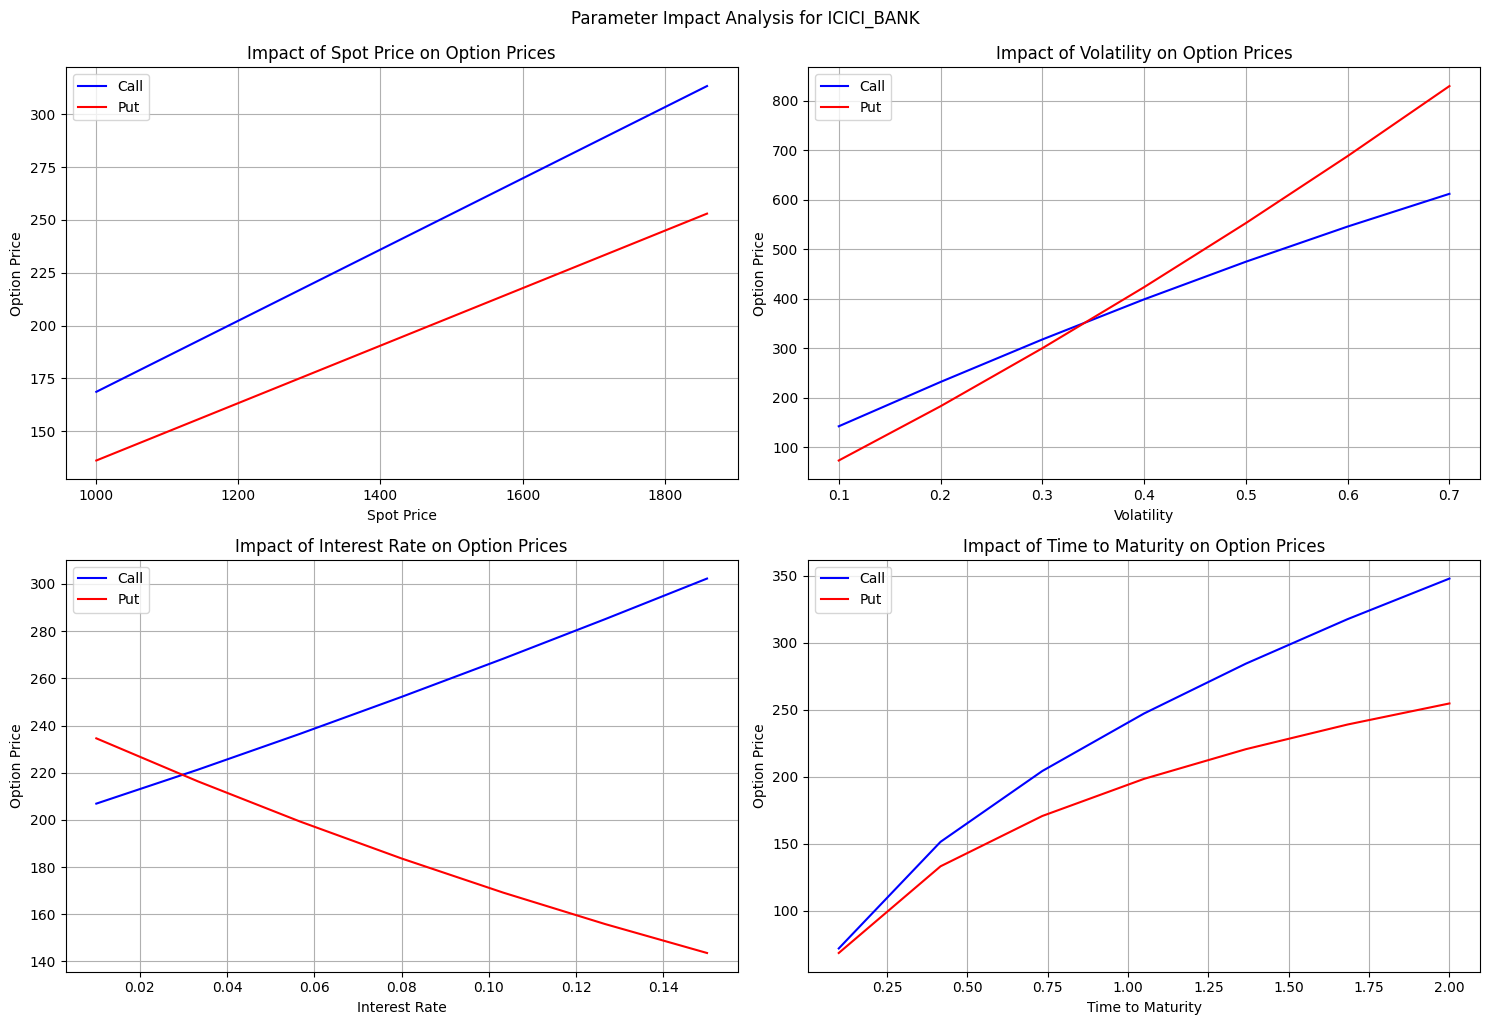

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_parameter_impact(asset_name, asset_params, r, T):
    """Simplified analysis for both call and put options"""
    S0 = asset_params['spot']
    sigma = asset_params['volatility']
    q = asset_params['dividend_yield']

    # Reduced simulations for faster results
    n_simulations = 5000
    n_steps = 100

    # Parameter ranges to test
    param_ranges = {
        'Spot Price': np.linspace(S0*0.7, S0*1.3, 7),
        'Volatility': np.linspace(0.1, 0.7, 7),
        'Interest Rate': np.linspace(0.01, 0.15, 7),
        'Time to Maturity': np.linspace(0.1, 2, 7)
    }

    # Create figure
    plt.figure(figsize=(15, 10))

    for i, (param_name, param_range) in enumerate(param_ranges.items(), 1):
        results = {'Call': [], 'Put': []}

        for param_value in param_range:
            # Adjust parameters based on what we're testing
            if param_name == 'Spot Price':
                S = param_value
                vol = sigma
                rate = r
                t = T
            elif param_name == 'Volatility':
                S = S0
                vol = param_value
                rate = r
                t = T
            elif param_name == 'Interest Rate':
                S = S0
                vol = sigma
                rate = param_value
                t = T
            elif param_name == 'Time to Maturity':
                S = S0
                vol = sigma
                rate = r
                t = param_value

            # Calculate prices
            paths = generate_price_paths(S, vol, rate, q, t, n_steps, n_simulations)

            # Floating strike
            call_price, _ = floating_strike_lookback(paths,  'call', rate, t)
            put_price, _ = floating_strike_lookback(paths,  'put', rate, t)

            results['Call'].append(call_price)
            results['Put'].append(put_price)

        # Plot results
        plt.subplot(2, 2, i)
        plt.plot(param_range, results['Call'], 'b-', label='Call')
        plt.plot(param_range, results['Put'], 'r-', label='Put')
        plt.title(f'Impact of {param_name} on Option Prices')
        plt.xlabel(param_name)
        plt.ylabel('Option Price')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle(f'Parameter Impact Analysis for {asset_name}', y=1.02)
    plt.show()

# Run analysis for all assets
for asset_name, params in assets.items():
    print(f"\nAnalyzing {asset_name}...")
    analyze_parameter_impact(asset_name, params, risk_free_rate, time_to_maturity)